In [1]:
from music21 import *
from pathlib import Path
import mido
from tqdm import tqdm
import numpy as np
import time
import sys
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras import Model
from math import *

from tensorflow.keras.backend import ctc_decode
port = mido.open_output()

Using TensorFlow backend.


<center>Define useful Functions</center>

In [2]:
def decode_categorical(music):
    notes, durations = [], []
    for i in music:
        raw = categorical_to_notes[i]
        note, duration = raw.split("|")
        notes.append(int(note))
        durations.append(float(duration))
    return notes, durations

def print_progress(c, t, msg = 'Note: '):
    text = '\r' + msg + str(c) + "  time: " + str(t)
    sys.stdout.write(text)
    sys.stdout.flush()

def play_song(music, start):
    time_now = 0
    notes_music, dur_music = decode_categorical(music)
    ticksPerQuarter = tpq[start]
    t = tempos[start]
    counter = 0
    start_time = time.time()
    defaults.ticksPerQuarter = ticksPerQuarter
    for n, d in zip(notes_music, dur_music):
        ticks = midi.translate.durationToMidi(duration.Duration(quarterLength = d))
        real_time = mido.tick2second(ticks, ticksPerQuarter , t)
        time.sleep(real_time)
        msg = mido.Message(type = 'note_on', note = n, velocity = 127)
        port.send(msg)
        counter += 1
        time_now = time_now + real_time
        print_progress(counter, time_now)
        
def create_midi_file(music, start, filename):
    notes_music, dur_music = decode_categorical(music)
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo = tempos[start]))
    mid.ticks_per_beat = tpq[start]

    for n, d in zip(notes_music, dur_music):
        ticks = midi.translate.durationToMidi(duration.Duration(quarterLength = d))
        msg = mido.Message(type = 'note_on', note = n, velocity = 127, time = ticks)
        track.append(msg)
#         msg = mido........

    mid.save(filename.format (1))
    return filename

<center>Import Dataset</center>

In [3]:
# decode('../piano_dataset')
notes = np.load('../datasets/Piano/notesDurations.npy')
tempos = np.load('../datasets/Piano/tempos.npy')
tpq = np.load('../datasets/Piano/tpq.npy')

In [ ]:
notes = np.load('../dataset/Guitar/notes.npy')[:1500000]
tempos = np.load('../dataset/Guitar/tempos.npy')[:1500000]
tpq = np.load('../dataset/Guitar/tpq.npy')[:1500000]

In [103]:
notes = np.load('../dataset/Shuffle/notes.npy')
tempos = np.load('../dataset/Shuffle/tempos.npy')
tpq = np.load('../dataset/Shuffle/tpq.npy')

In [4]:
unique = np.unique(notes)
notes_to_categorical = {o:i for i, o in enumerate(unique)}
categorical_to_notes = {i:o for i, o in enumerate(unique)}
cat_notes = [notes_to_categorical[i] for i in notes]

In [5]:
batch_size = 64
seq_length = 20
lstm_cells = 512
cardinality = max(cat_notes) + 1
print (cardinality)

2059


<center>Create Training Model</center>

In [6]:
def create_model(batch_size, inp_card,emb_size = 100, 
                   lstm_cells = 256, dropout = 0.4):
    inp = Input (batch_shape=(batch_size, None), dtype = 'int32', name = 'inp')
    inp_emb = Embedding(input_dim = inp_card, output_dim= emb_size, name = 'inp_emb')(inp)
                 
    lstm1 = LSTM(lstm_cells, return_sequences= True, stateful= True, name = 'lstm1')(inp_emb)
    drp1 = Dropout(dropout)(lstm1)
    lstm2 = LSTM(lstm_cells, return_sequences= True, stateful= True, name = 'lstm2')(drp1)
    drp2 = Dropout(dropout)(lstm2)
    lstm3 = LSTM(lstm_cells, return_sequences= True, stateful= True, name = 'lstm3')(drp2)
    drp3 = Dropout(dropout)(lstm3)
    lstm4 = LSTM(lstm_cells, stateful= True, name = 'lstm4')(drp3)
    drp4 = Dropout(dropout)(lstm4)
    
    out = Dense(inp_card, activation= 'softmax', name = 'out')(drp4)
    
    model = Model(inputs= inp, outputs= out)
    return model

In [10]:
model = create_model(batch_size, cardinality)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (64, None)                0         
_________________________________________________________________
inp_emb (Embedding)          (64, None, 100)           205900    
_________________________________________________________________
lstm1 (LSTM)                 (64, None, 256)           365568    
_________________________________________________________________
dropout_1 (Dropout)          (64, None, 256)           0         
_________________________________________________________________
lstm2 (LSTM)                 (64, None, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (64, None, 256)           0         
_________________________________________________________________
lstm3 (LSTM)                 (64, None, 256)           525312    
__________

In [7]:
def get_train_size(inp_size, batch_size):
    for i in range (inp_size, 0, -1):
        if i % batch_size == 0:
            return i
        
def create_dataset(notes, seq_length, batch_size):
    size = get_train_size(len(notes) - seq_length - 1, batch_size)
    inp, outp = [], []
    for i in tqdm(range (size)):
        inp.append(notes[i: i + seq_length])
        outp.append(notes[i + seq_length])
    inp = np.array(inp)
    outp = np.array(outp)
    return inp, outp

In [8]:
inp, outp = create_dataset(cat_notes, seq_length, batch_size)

100%|████████████████████████████████████████████████████████████████████| 1422592/1422592 [00:03<00:00, 367908.79it/s]


In [9]:
len(cat_notes)

1422671

<center>Evaluate Model</center>

In [10]:
def predict(pred_model, inp, steps, start):
    pred_model.reset_states()
    if start == -1:
        start = np.random.randint(0, len(cat_notes))
    source = inp[start].reshape((1, -1))
    music = list(source[0])
    for i in tqdm(range (steps)):
        prediction = pred_model.predict(x = source, batch_size = 1)
        prediction = np.argmax(prediction)
        source = np.append(source, prediction)[1:].reshape((1, -1))
        music.append(prediction)
    return music, start

In [11]:
pred_model = create_model(1, cardinality, lstm_cells = 512, dropout = 0)
pred_model.load_weights('Weights/20to1_Piano_512_269_1.1553.hdf5')
error = 1.1553

In [18]:
pred_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (1, None)                 0         
_________________________________________________________________
inp_emb (Embedding)          (1, None, 100)            205900    
_________________________________________________________________
lstm1 (LSTM)                 (1, None, 512)            1255424   
_________________________________________________________________
dropout_9 (Dropout)          (1, None, 512)            0         
_________________________________________________________________
lstm2 (LSTM)                 (1, None, 512)            2099200   
_________________________________________________________________
dropout_10 (Dropout)         (1, None, 512)            0         
_________________________________________________________________
lstm3 (LSTM)                 (1, None, 512)            2099200   
__________

In [21]:
start = 1421453
music, start = predict(pred_model, inp, 400, start)
play_song(music, start)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:22<00:00, 17.40it/s]


Note: 394  time: 59.904199999999854

KeyboardInterrupt: 

In [107]:
filename = 'Piano Samples/samples_512/seq_' + str(lstm_cells) + "_" + str(start) + "_" + str(error) + '.mid'
create_midi_file(music, start, filename)

'../../Music Generation/FFLSTM/Mixed Samples/samples_512/seq_512_929590_1.616.mid'

In [ ]:
import os
os.listdir('../../Music Generation/')

In [ ]:
def beam_search_predict(pred_model, inp, steps, k):
    pred_model.reset_states()
    start_time = time.time()
    sequences = [[list(), 1.0]]
    for step in tqdm(range (steps)):
        all_candidates  = list()
        for i in range (len (sequences)):
            seq, score = sequences[i]
            temp_source = np.append(source, seq)[len(seq):].reshape(1, -1)
            prediction = pred_model.predict(x = temp_source, batch_size = 1)
            prediction = prediction.flatten()
            for j in range(len(prediction)):
                if prediction[j] != 0:
                    candidate = [seq + [j], score * -log(prediction[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    print ('Took: ', time.time() - start_time, 'sec')
    return sequences[0]

In [ ]:
# start = np.random.randint(0, len(cat_notes))
source = inp[start]
beam_music = beam_search_predict(pred_model, source, 40, 5)
beam_music = np.append(source, beam_music[0], axis = 0)
print (beam_music)
play_song(beam_music, start)

In [ ]:
play_song(beam_music, start)

In [ ]:
greedy_music = beam_search_predict(pred_model, source, 300, 1)
greedy_music = np.append(source, greedy_music[0], axis = 0)
print (greedy_music)
play_song(greedy_music, start)

In [ ]:
print (greedy_music)

In [ ]:
def search(model, src_input, k=1, sequence_max_len=25):
    # (log(1), initialize_of_zeros)
    k_beam = [(0, [0]*(sequence_max_len+1))]

    # l : point on target sentence to predict
    for l in range(sequence_max_len):
        all_k_beams = []
        for prob, sent_predict in k_beam:
            s = np.append(src_input, np.argmax(sent_predict))
            predicted = model.predict(s, batch_size = 1).flatten()
            # top k!
            possible_k = predicted[l].argsort()[-k:][::-1]

            # add to all possible candidates for k-beams
            all_k_beams += [
                (
                    sum(np.log(predicted[i][sent_predict[i+1]]) for i in range(l)) + np.log(predicted[l][next_wid]),
                    list(sent_predict[:l+1])+[next_wid]+[0]*(sequence_max_len-l-1)
                )
                for next_wid in possible_k
            ]

        # top k
        k_beam = sorted(all_k_beams)[-k:]

    return k_beam

In [ ]:
start = np.random.randint(0, len(cat_notes))
source = inp[start]
beam_music = search(pred_model, source)
beam_music = np.append(source, beam_music[0], axis = 0)
print (beam_music)
play_song(beam_music, start)

In [ ]:
model = create_model(256, cardinality)
opt = keras.optimizers.adam()
model.compile(opt, loss = 'sparse_categorical_crossentropy')
loss = []
lr = []
for i in range (0, 500):
    K.set_value(model.optimizer.lr, np.exp(i/80)/10000)
    a = model.train_on_batch(inp[i*64 : i*64 +64], outp[i*64 : i*64 +64])
    loss.append(a)
    lr.append(np.exp(i/80)/10000)
    print (i)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lr, loss)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [ ]:
model = create_model(batch_size, cardinality, dropout= 0.0, lstm_cells= 256)
model.compile ('rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
history = model.fit(x = inp[:2048*4], y = outp[:2048*4], 
        validation_data=(inp[2048*4:2048*4 + 512], outp[2048*4:2048*4 +512]), epochs = 100, 
          batch_size = batch_size, verbose = 2)

In [21]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

In [ ]:
2048*4

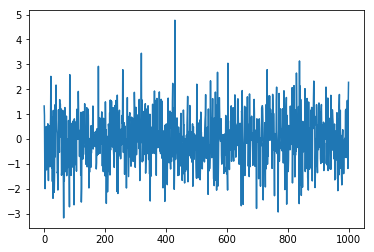

In [23]:
plt.plot(np.random.randn(1000))

In [126]:
# define the model
model = keras.Sequential()
model.add(pred_model.get_layer('inp_emb'))
# compile the model
model.compile(optimizer='adam', loss = 'mse')
# summarize the model
print(model.summary())
model.set_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_emb (Embedding)          multiple                  243900    
Total params: 243,900
Trainable params: 243,900
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
a = np.zeros((max(cat_notes), 100))
for i in range (max(cat_notes)):
    a[i] = model.predict(np.array([i]))

In [130]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(a)
X_embedded.shape

(2438, 2)

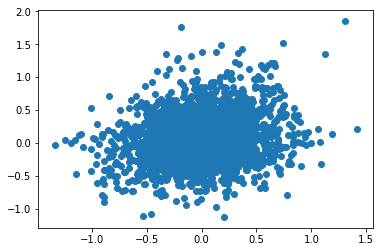

In [131]:
plt.scatter(a[:,0], a[:,1])

In [134]:
pred_model.get_weights()[0]

array([[ 0.38008648, -0.16381885,  0.11532775, ..., -0.11792203,
        -0.16795221,  0.18744501],
       [-0.15319872,  0.16554406, -0.15693069, ..., -0.02008441,
         0.00041295, -0.00460673],
       [-0.03835658, -0.17053121, -0.1603761 , ...,  0.28102586,
        -0.03559452,  0.4122688 ],
       ...,
       [ 0.12487192, -0.11440939, -0.31809184, ...,  0.14948356,
        -0.06850366,  0.19561554],
       [ 0.23688048, -0.03623701, -0.28688443, ..., -0.04834721,
         0.1639376 , -0.03024614],
       [-0.11499   ,  0.27004316, -0.08497734, ...,  0.06895045,
         0.04987559, -0.03354265]], dtype=float32)

In [143]:
i = Input (batch_shape=(batch_size, None , 10), dtype = 'float32', name = 'inp')
lstm1 = LSTM(lstm_cells, return_sequences= True, stateful= True, name = 'lstm1')(i)
m = Model(i, lstm1)

In [145]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (64, None, 10)            0         
_________________________________________________________________
lstm1 (LSTM)                 (64, None, 512)           1071104   
Total params: 1,071,104
Trainable params: 1,071,104
Non-trainable params: 0
_________________________________________________________________


In [148]:
def get_lstm_param(inp, lstm_cells):
    return 4*((inp + 1) * lstm_cells + lstm_cells*lstm_cells)

In [17]:
notes = np.load('../datasets/Piano/')
# unique = np.unique(notes)
# notes_to_categorical = {o:i for i, o in enumerate(unique)}
# categorical_to_notes = {i:o for i, o in enumerate(unique)}
# cat_notes = [notes_to_categorical[i] for i in notes]

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/Piano/aug_piano_notes.npy'

In [12]:
real_notes = []
for i in notes:
    n = i.split("|")[0]
    real_notes.append(int (n))
print (real_notes[:10])

[81, 81, 88, 88, 88, 88, 86, 86, 88, 88]


(array([  4006.,  42833.,  96619., 218746., 303994., 351175., 267527.,
        103018.,  30852.,   3901.]),
 array([ 21. ,  29.6,  38.2,  46.8,  55.4,  64. ,  72.6,  81.2,  89.8,
         98.4, 107. ]),
 <a list of 10 Patch objects>)

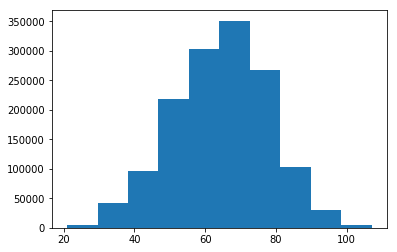

In [14]:
import matplotlib.pyplot as plt
plt.hist(real_notes)

In [ ]:
notes = np.load('../../Music Generation/datasets/Piano/aug_piano_notes.npy')
